# vinsight - Visualization Tutorial 1

in this notebook you will learn the intuition behind the features of the interpretability framework and how to us them.

## Gradient Class Activation Mapping (Grad-CAM) with ResNet

Demonstration of visualizing the class activation mapping for an image classification example with ResNet.


In [3]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2  
%cd ../src

import data_utils
from data_utils import DataConfig
from model_utils import ModelConfig
from model_utils import split_model_with_classification
from PIL import Image
import plot_utils
from vinsight.visualization import SaliencyMap
from vinsight.visualization import SpatialSplit
from vinsight.visualization import ChannelSplit
from vinsight.visualization import NeuronSplit
from vinsight.visualization import NeuronSelector

import torch
from torch import Tensor
from torch.nn import Softmax
from torch.nn.functional import interpolate

from torchvision import models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[Errno 2] No such file or directory: '../src'
/home/christina/Development/interpretability-framework/notebooks/exploration_notebooks


## Step 1: Load pretrained model

In our example we use a pretrained ResNet for demonstration.

In [4]:
device = torch.device("cuda" if torch.tensor([]).is_cuda else "cpu")

model = models.resnet50(pretrained=True)

model.eval()
model.to(device);

## Step 2: Load Image

In [6]:
img_path = "../../data/imagenet_example_283.jpg"
#img_path = "../data/ood_example.jpg"

# load image as torch tensor for computation, we can also load alexnet data for ResNet.
input_ = data_utils.get_example_from_path(img_path, DataConfig.ALEX_NET)

# load image as PIL Image for plotting and resizing
img = Image.open(img_path)
H, W = img.size

## Step 3: Select layer of interest

in ResNet, we have 9 layers, where 8 is the last feature layer and 10 the classification layer
Input: a list of layers which should be visualized as attribution.
**Note: choose a layers between 1 and 8 for ResNet**

### Visualization of layer attributions
it is possible to visualize attributions of a single layer, or from several layers together. In this example we demonstrate both.

In [70]:
# example ResNet selection
selected_layer_single = 8
selected_layer_group = [5, 6, 7]

## Step 4: Select layer splits - Class Visualization example
in this example we want to analyze the top two classes of the classification output. 
This means, we create a top-layer-selector with a Neuronsplit with the class of choice as split element.
class 283 is the max classification for the imagenet_example_283. 

Additionally, it is possible to create a bottom_layer_selector to visualize the class activations in greater detail, e.g. channel-wise or neuron-wise.

In [67]:
top_layer_selector = NeuronSelector(NeuronSplit(), [283])
bottom_layer_selector = NeuronSelector(NeuronSplit(), [6, 0, 0])

## Step 5: Split the model into base_layers and inspection_layers
splitting the model with classification returns a list of base layers up to the selected single layer and the list of layers (inspection layers) from the selected layer until the last layer of the model, the classification layer. The output of the inspected layers is a classification with dimension (1, 1000)

In [52]:
base_layers, inspected_layers = split_model_with_classification(model, ModelConfig.RES_NET, selected_layer_single)

## Step 6: Generate Saliency Map

### Example 1: Compute saliency map without bottom_layer_selector

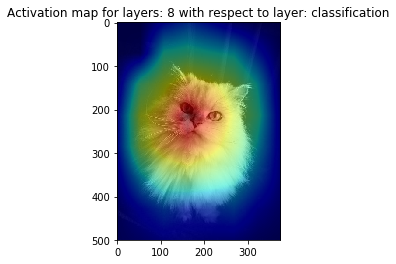

In [53]:
saliency = SaliencyMap(inspected_layers, top_layer_selector, base_layers, bottom_layer_selector=None).visualize(input_)
        
# upsample saliency to the pixel dimensions of the image
sal_map = interpolate(saliency.unsqueeze(dim=0).unsqueeze(dim=0), size=(H, W), mode='bilinear', align_corners=True)
        
# plot saliencies with the input image
plot_utils.plot_saliency(sal_map, img, selected_layer_single, output_layer="classification")

### Example 2: Compute saliency map with additional bottom layer neuron split.
with this bottom_layer_split we analyse the total saliencies from above 
(total feature map with dimension (c, h, w)) and select a specific neuron which we want to inspect w.r.t. the top_layer_selector, but isolated from the rest of the feature map.

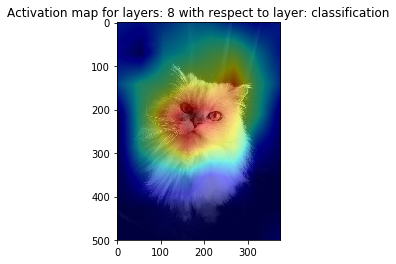

In [68]:
saliency = SaliencyMap(inspected_layers, top_layer_selector, base_layers, bottom_layer_selector).visualize(input_)
        
# upsample saliency to the pixel dimensions of the image
sal_map = interpolate(saliency.unsqueeze(dim=0).unsqueeze(dim=0), size=(H, W), mode='bilinear', align_corners=True)
        
# plot saliencies with the input image
plot_utils.plot_saliency(sal_map, img, selected_layer_single, output_layer="classification")

### Example 3: Compute saliency map of a layer group with bottom layer neuron split
This example demonstrates how to analyse attributions of several layers together, in other word, to compute their mean saliency w.r.t to the classification output. 
Additionally we apply a bottom layer neuron split.

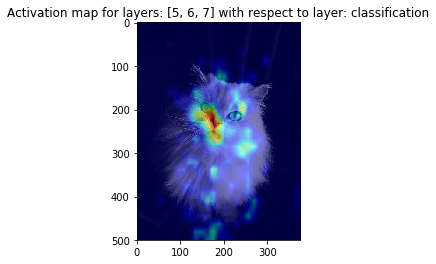

In [73]:
saliency_collector = torch.zeros((1, 1, H, W))

for layer in selected_layer_group:
    
    base_layers, inspected_layers = split_model_with_classification(model, ModelConfig.RES_NET, layer)
    
    saliency = SaliencyMap(inspected_layers, top_layer_selector, base_layers, bottom_layer_selector).visualize(input_)
        
    # upsample saliency to the pixel dimensions of the image
    sal_map = interpolate(saliency.unsqueeze(dim=0).unsqueeze(dim=0), size=(H, W), mode='bilinear', align_corners=True)
    
    saliency_collector = torch.add(saliency_collector, sal_map)

mean_saliency = torch.div(saliency_collector, len(selected_layer_group))

# plot saliencies with the input image
plot_utils.plot_saliency(mean_saliency, img, selected_layer_group, output_layer="classification")